In [ ]:
import os
import platform

# Get CPU name
cpu_name = platform.processor()

# Get CPU architecture
cpu_arch = platform.architecture()

# Get the number of CPU cores
cpu_cores = os.cpu_count()

print(f"CPU Name: {cpu_name}")
print(f"CPU Architecture: {cpu_arch[0]}")
print(f"Number of Cores: {cpu_cores}")

CPU Name: x86_64
CPU Architecture: 64bit
Number of Cores: 2


In [ ]:
import pandas as pd
import numpy as np
import ast
import imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
# Import necessary libraries
from google.colab import drive
from ast import literal_eval
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import tqdm
import shap

In [ ]:
from google.colab import drive
# Mount Google Drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_initial = pd.read_csv('/content/drive/MyDrive/CSM_ML&DL_Project/Code/Data/densenet_train_embeddings.csv', quotechar='"', on_bad_lines='skip')
test_initial = pd.read_csv('/content/drive/MyDrive/CSM_ML&DL_Project/Code/Data/densenet_test_embeddings.csv', quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv('/content/drive/MyDrive/CSM_ML&DL_Project/Code/Data/densenet_valid_embeddings.csv', quotechar='"', on_bad_lines='skip')

print(test_initial.columns)
test_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


## Convert embeddings from str to list (a bit long for large data sets)

In [ ]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

## Remove not used columns

In [ ]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])

## Remove unprocessed rows (embeddings < 10)

In [ ]:
initial_size = test.shape[0]
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0]
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0]
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0]
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = valid.shape[0]
valid = valid[valid['embeddings'].str.len() > 10]
final_size = valid.shape[0]
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 3


## Convert age to binary to study bias

In [ ]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

<ipython-input-7-11797956be94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['age'] = (valid['age'] >= a).astype(int)
<ipython-input-7-11797956be94>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age'] = (train['age'] >= a).astype(int)


In [ ]:
print("Initial sex Distribution:")
print(train['sex'].value_counts())

print("\nInitial Race Distribution:")
print(train['race'].value_counts())

print("\nInitial Age Distribution:")
print(train['age'].value_counts())

print("\nInitial Health Distribution:")
print(train['insurance_type'].value_counts())

Initial sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Initial Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64

Initial Age Distribution:
age
0    42267
1    24929
Name: count, dtype: int64

Initial Health Distribution:
insurance_type
1    43076
2    18340
0     5780
Name: count, dtype: int64


## Visualize distribution of diseases

In [ ]:
col = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'No Finding']

print(f"Distribution in train set")
for disease in col:
    counts = train[disease].value_counts()
    print(f"{disease}: - 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")
print(f"Distribution in test set")
for disease in col:
    counts = test[disease].value_counts()
    print(f"{disease}:- 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")


Distribution in train set
Enlarged Cardiomediastinum: - 0s: 63738, 1s: 3458
Cardiomegaly: - 0s: 58986, 1s: 8210
Lung Opacity: - 0s: 33926, 1s: 33270
Lung Lesion: - 0s: 64703, 1s: 2493
Edema: - 0s: 51202, 1s: 15994
Consolidation: - 0s: 62851, 1s: 4345
Pneumonia: - 0s: 65571, 1s: 1625
Atelectasis: - 0s: 57067, 1s: 10129
Pneumothorax: - 0s: 60688, 1s: 6508
Pleural Effusion: - 0s: 40484, 1s: 26712
Pleural Other: - 0s: 66251, 1s: 945
Fracture: - 0s: 64485, 1s: 2711
No Finding: - 0s: 61107, 1s: 6089
Distribution in test set
Enlarged Cardiomediastinum:- 0s: 38350, 1s: 1957
Cardiomegaly:- 0s: 35347, 1s: 4960
Lung Opacity:- 0s: 20463, 1s: 19844
Lung Lesion:- 0s: 38810, 1s: 1497
Edema:- 0s: 30622, 1s: 9685
Consolidation:- 0s: 37814, 1s: 2493
Pneumonia:- 0s: 39325, 1s: 982
Atelectasis:- 0s: 34107, 1s: 6200
Pneumothorax:- 0s: 36201, 1s: 4106
Pleural Effusion:- 0s: 24418, 1s: 15889
Pleural Other:- 0s: 39739, 1s: 568
Fracture:- 0s: 38699, 1s: 1608
No Finding:- 0s: 36645, 1s: 3662


## Train Evaluation Test

In [ ]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())

In [ ]:


# Diseases to predict
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            #  'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
#diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']
# diseases = ['Lung Opacity', 'Pleural Effusion']

cath = ['age', 'sex', 'race', 'insurance_type']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']


train_cath = train[cath]
test_cath = test[cath]
val_cath = valid[cath]


In [ ]:
train_cath = train_cath.reset_index(drop=True)
test_cath = test_cath.reset_index(drop=True)
val_cath = val_cath.reset_index(drop=True)

In [ ]:
# Combine embeddings with categorical features
train_embeddings = pd.concat([train_cath, train_embeddings], axis=1)
test_embeddings = pd.concat([test_cath, test_embeddings], axis=1)
valid_embeddings = pd.concat([val_cath, valid_embeddings], axis=1)

In [ ]:
learning_rate = 0.0005
weight_decay = 0
dropout = 0.5
batch_size = 128

In [ ]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - Convert dataframes to tensors and create dataloaders
X_train = torch.tensor(train_embeddings.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
X_test = torch.tensor(test_embeddings.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)
X_valid = torch.tensor(valid_embeddings.values).float().to(device)
y_valid = torch.tensor(y_valid.values).float().to(device)




train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
valid_data = TensorDataset(X_valid, y_valid)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


In [ ]:

# Assuming y_train is a tensor of shape (num_samples, num_classes)
# where each element is 0 or 1 indicating the absence or presence of a class

def calculate_sample_weights(y_train):
    # Calculate the frequency of each class
    class_counts = y_train.sum(axis=0)
    print(class_counts)
    # Compute the weight for each class (inverse frequency, normalized)
    class_weights = 1. / (class_counts + 1e-5)  # Add a small value to avoid division by zero
    class_weights /= class_weights.sum()  # Normalize so that sum of weights is 1
    print(class_weights)

    # Compute the sample weights
    sample_weights = torch.mm(y_train, class_weights.unsqueeze(1)).squeeze()

    return sample_weights

sample_weights = calculate_sample_weights(y_train)

# Convert sample weights to a Sampler compatible format
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create DataLoader using the WeightedRandomSampler
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler)


tensor([ 8210., 33270., 15994., 26712.], device='cuda:0')
tensor([0.4837, 0.1194, 0.2483, 0.1487], device='cuda:0')


In [ ]:

# Define the simplified neural network
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.fc3 = nn.Linear(128, output_size)  # Output layer size = number of diseases
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(dropout)  # Dropout for regularization

    def forward(self, x):
        x = self.fc1(x)  # First linear transformation
        x = self.relu(x)  # Activation function
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)  # Final linear transformation to output size
        return x


In [ ]:
# Calculate weights inversely proportional to class frequencies
class_counts = y_train.sum(axis=0)
class_weights = 1.0 / (class_counts + 1e-5)
class_weights = class_weights / class_weights.mean()  # Normalizing


# Example to increase the weight of positive examples in loss calculation
pos_weights = torch.ones([len(diseases)]).to(device)  # one weight per class
pos_weights *= 5  # Increasing the weights for positive examples

# Use these weights in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


In [ ]:
model = MultiLabelNN(1028, len(diseases), dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=1)

In [36]:
def train_model(train_loader, validation_loader, model, criterion, optimizer, scheduler, num_epochs, patience=3):
    model.train()
    training_stats = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_val_loss = 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        training_stats['train_loss'].append(total_loss / len(train_loader))

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(validation_loader)
        training_stats['val_loss'].append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # reset counter if validation loss improves
        else:
            patience_counter += 1
            print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print('Stopping early due to no improvement in validation loss.')
                break

        # Update the learning rate
        scheduler.step()

    return model, training_stats


Epoch 1/20, Training Loss: 0.5550, Validation Loss: 0.5202
Epoch 2/20, Training Loss: 0.5558, Validation Loss: 0.5132
Epoch 3/20, Training Loss: 0.5547, Validation Loss: 0.5194
Validation loss did not improve. Patience: 1/3
Epoch 4/20, Training Loss: 0.5532, Validation Loss: 0.5091
Epoch 5/20, Training Loss: 0.5522, Validation Loss: 0.5134
Validation loss did not improve. Patience: 1/3
Epoch 6/20, Training Loss: 0.5506, Validation Loss: 0.5105
Validation loss did not improve. Patience: 2/3
Epoch 7/20, Training Loss: 0.5506, Validation Loss: 0.5092
Validation loss did not improve. Patience: 3/3
Stopping early due to no improvement in validation loss.


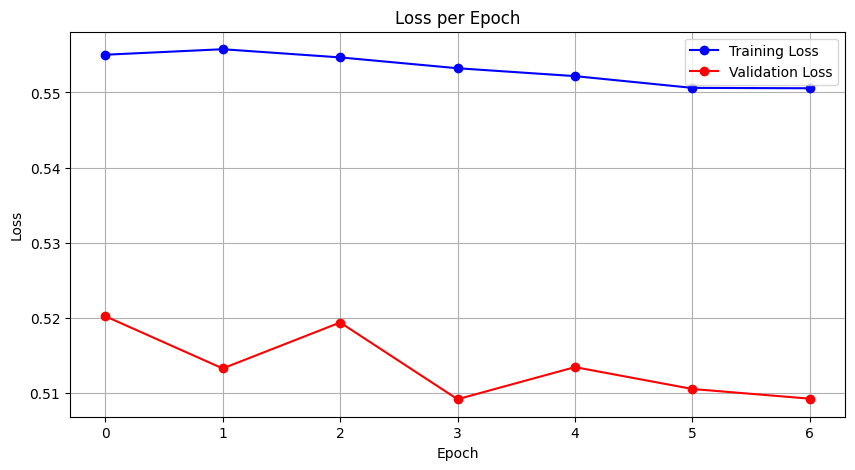

In [37]:
# Run training
nb_epoch = 20
model, stats = train_model(train_loader, valid_loader, model, criterion, optimizer, scheduler, nb_epoch)

# Plotting the training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
# Function to evaluate the model
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predicted = torch.sigmoid(output).cpu().numpy()
            all_preds.append(predicted)
            all_targets.append(target.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return model, all_preds, all_targets

In [39]:
# Evaluate on test data
mopredictions, targets = evaluate_model(test_loader)

# Create the no finding column
updated_predictions = []

for row in predictions:
    # Check if all elements in the row are less than or equal to 0.5
    if np.all(row <= 0.5):
        new_row = np.append(row, 1)
    else:
        new_row = np.append(row, 0)
    updated_predictions.append(new_row)

predictions = np.array(updated_predictions)

updated_targets = []
for target, no_finding_target in zip(targets, y_no_finding):
    new_target = np.append(target, no_finding_target)
    updated_targets.append(new_target)

targets = np.array(updated_targets)



ValueError: too many values to unpack (expected 2)

In [ ]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

In [ ]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0

        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(predictions, targets)
print(metrics)

In [40]:
auc_dict = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUC':
            auc_dict[disease] = value

auprc = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUPRC':
            auprc[disease] = value

auprc

{'Cardiomegaly': 0.3934378941709847,
 'Lung Opacity': 0.6186677303885922,
 'Edema': 0.5034636107232338,
 'Pleural Effusion': 0.6998406955143759}

## Compute Metrics for different categories

In [41]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }


metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }


metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

## SHAP NN Interpretability

SHAP Summary for Cardiomegaly
shap_values_per_output.shape: (1000, 1028)
test_samples_np.shape: (1000, 1028)


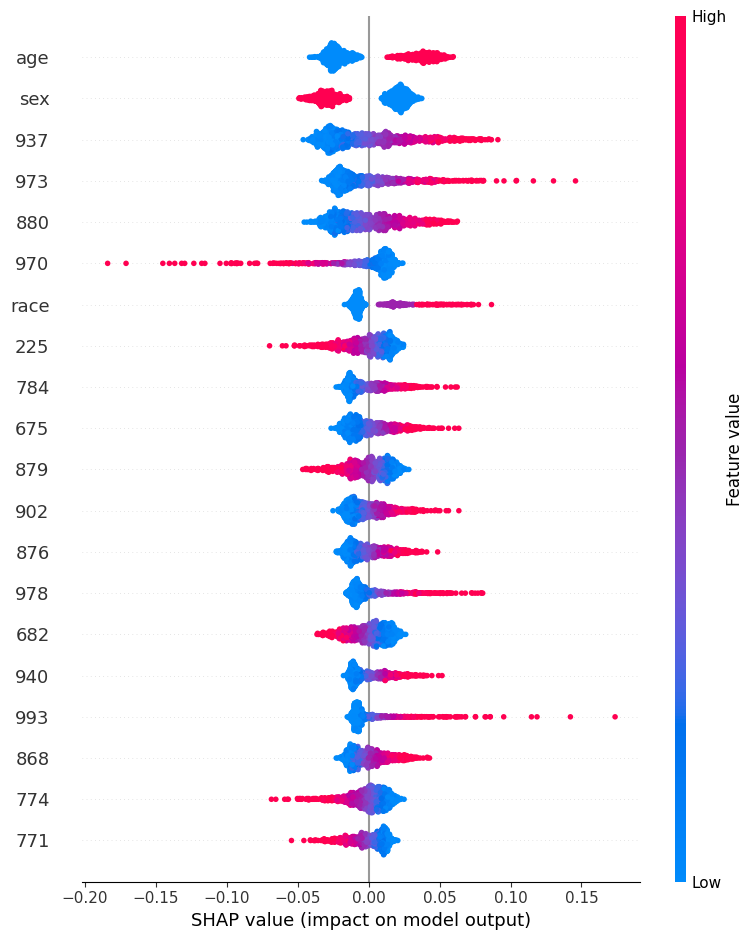

SHAP Summary for Lung Opacity
shap_values_per_output.shape: (1000, 1028)
test_samples_np.shape: (1000, 1028)


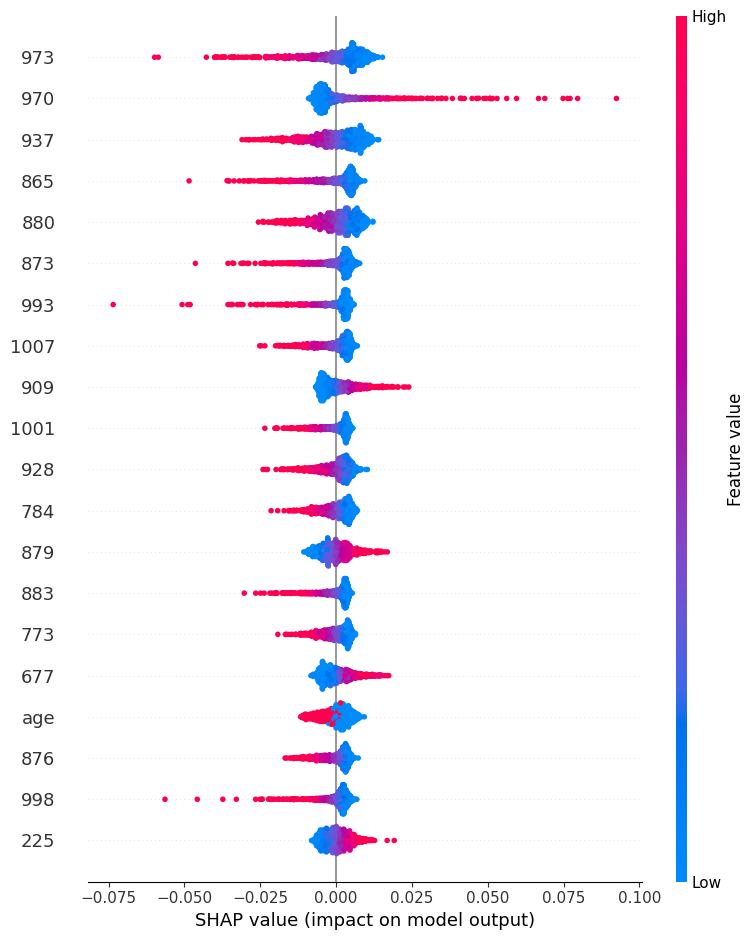

SHAP Summary for Edema
shap_values_per_output.shape: (1000, 1028)
test_samples_np.shape: (1000, 1028)


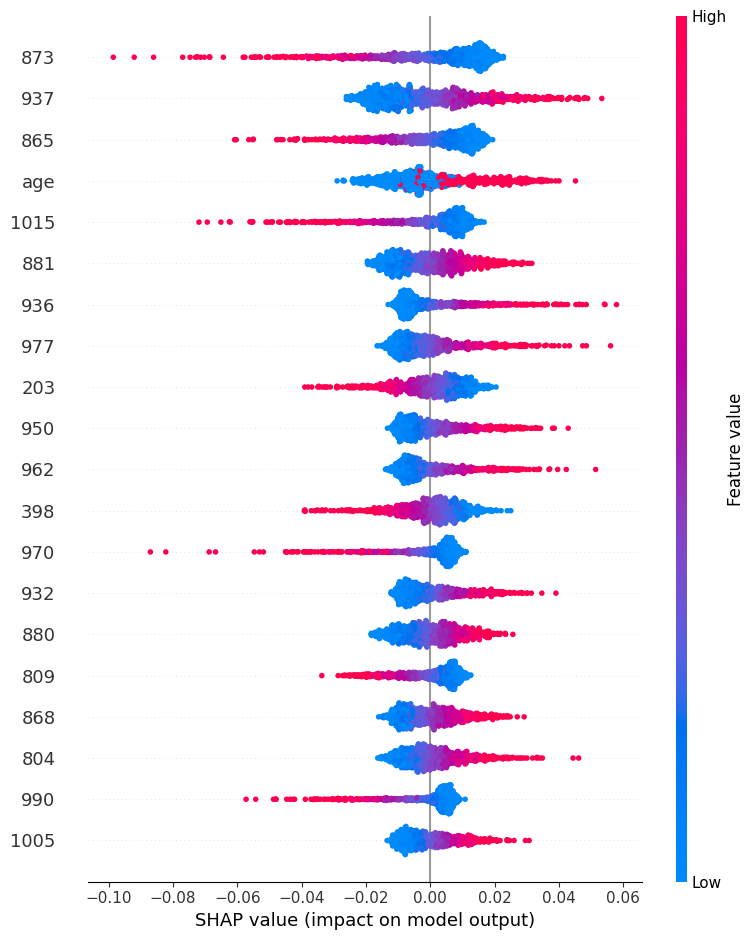

SHAP Summary for Pleural Effusion
shap_values_per_output.shape: (1000, 1028)
test_samples_np.shape: (1000, 1028)


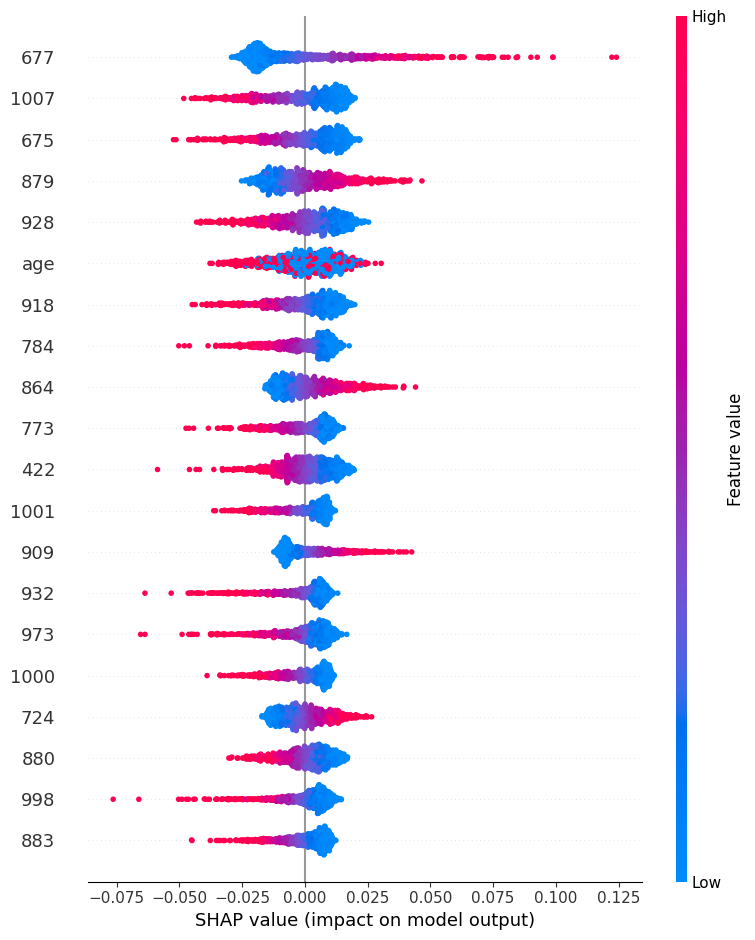

In [47]:
# Set the device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to CUDA
model.to(device)

# Select a subset of the training data for background and test samples
background = X_train[:2000].to(device)  # Adjust sizes as needed
test_samples = X_test[:1000].to(device)

# Define a wrapper model that includes the sigmoid activation
class WrappedModel(nn.Module):
    def __init__(self, base_model):
        super(WrappedModel, self).__init__()
        self.base_model = base_model
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        logits = self.base_model(x)
        probs = self.sigmoid(logits)
        return probs

# Wrap the base model
wrapped_model = WrappedModel(model)
wrapped_model.eval()
wrapped_model.to(device)

# Create a GradientExplainer for the wrapped model
explainer = shap.GradientExplainer(wrapped_model, background)

# Compute SHAP values for the test samples
shap_values = explainer.shap_values(test_samples)  # Shape: (num_samples, num_features, num_outputs)

# Get feature names from your embeddings DataFrame
feat_names = list(test_embeddings.columns)

# Convert test samples to numpy array for plotting
test_samples_np = test_samples.cpu().numpy()

# Print shapes for debugging
#print(f"Shape of shap_values: {shap_values.shape}")
#print(f"Shape of test_samples_np: {test_samples_np.shape}")
#print(f"Number of features: {len(feat_names)}")

# Plot SHAP summary plots for each disease
for idx, disease_name in enumerate(diseases):
    print(f"SHAP Summary for {disease_name}")

    # Extract SHAP values for the current disease
    shap_values_per_output = shap_values[:, :, idx]  # Shape: (num_samples, num_features)

    # Verify shapes
    print(f"shap_values_per_output.shape: {shap_values_per_output.shape}")
    print(f"test_samples_np.shape: {test_samples_np.shape}")

    # Plot the SHAP summary
    shap.summary_plot(shap_values_per_output, test_samples_np, feature_names=feat_names)


Analyzing the feature importance across all diseases

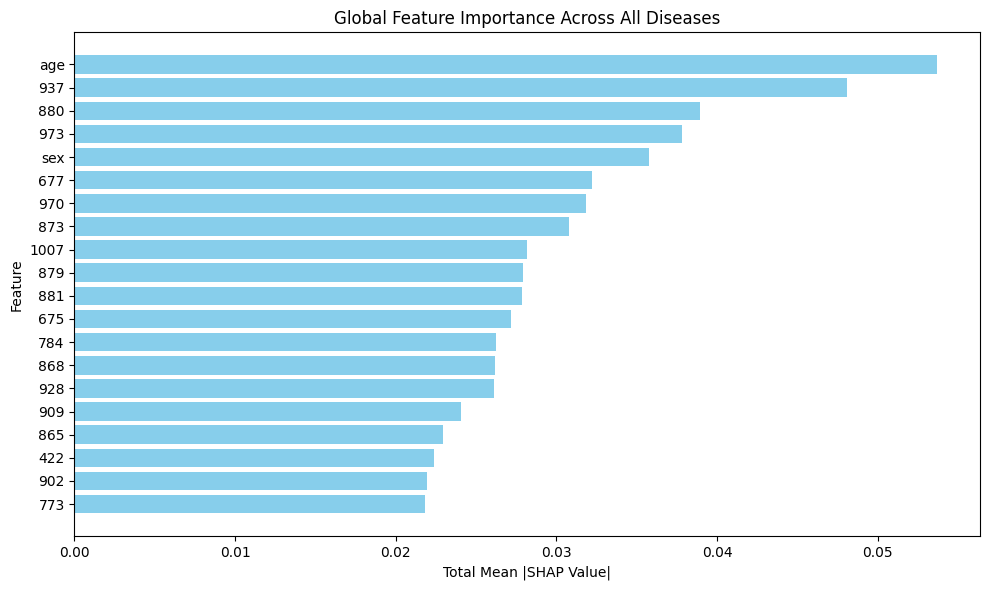

In [48]:
# shap_values: SHAP values array of shape (num_samples, num_features, num_outputs)
# feat_names: List of feature names
# diseases: List of disease names

# Step 1: Calculate mean absolute SHAP values across all samples for each feature and disease
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)  # Shape: (num_features, num_outputs)

# Step 2: Sum the mean absolute SHAP values across all diseases to get a total importance per feature
total_mean_abs_shap = mean_abs_shap_values.sum(axis=1)  # Shape: (num_features,)

# Step 3: Identify the top N features with the highest total importance
top_n = 20  # You can adjust this number based on how many top features you want to visualize
top_indices = np.argsort(total_mean_abs_shap)[::-1][:top_n]  # Indices of top features
top_features = [feat_names[i] for i in top_indices]
top_values = total_mean_abs_shap[top_indices]

# Step 4: Prepare numerical positions for y-axis
y_positions = np.arange(len(top_features))  # Numerical positions for the y-axis

# Step 5: Plot the top features using a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(y_positions, top_values[::-1], color='skyblue')  # Reverse top_values to match the order
plt.yticks(y_positions, top_features[::-1])  # Set the y-axis tick labels
plt.title("Global Feature Importance Across All Diseases")
plt.xlabel("Total Mean |SHAP Value|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


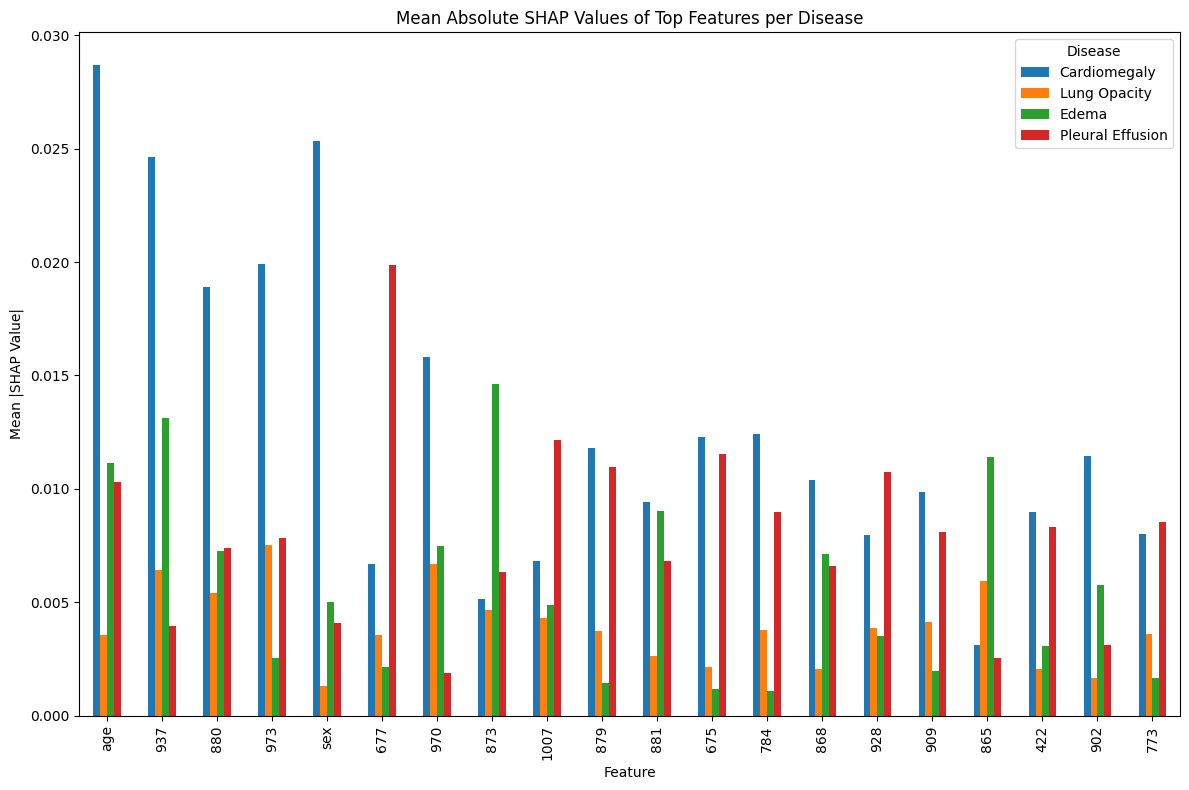

In [49]:
import pandas as pd

# Create a DataFrame for the top features and their mean absolute SHAP values per disease
top_mean_abs_shap = mean_abs_shap_values[top_indices, :]  # Shape: (top_n, num_outputs)
shap_df = pd.DataFrame(top_mean_abs_shap, index=top_features, columns=diseases)

# Plotting
shap_df.plot(kind='bar', figsize=(12, 8))
plt.title("Mean Absolute SHAP Values of Top Features per Disease")
plt.xlabel("Feature")
plt.ylabel("Mean |SHAP Value|")
plt.legend(title="Disease")
plt.tight_layout()
plt.show()

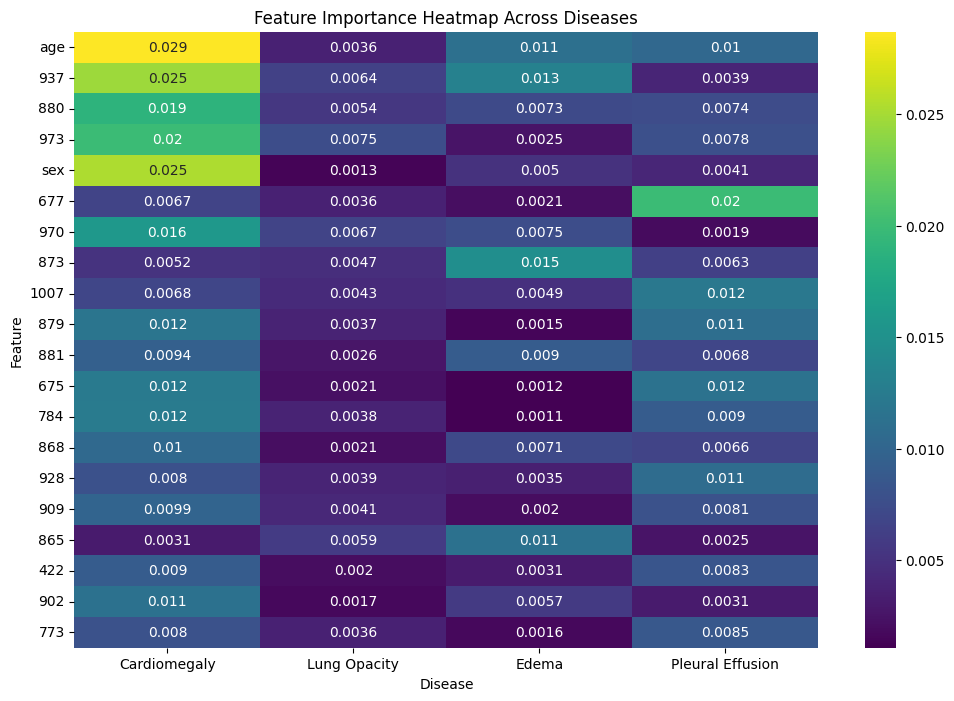

In [50]:
# Calculate mean absolute SHAP values for each feature and disease
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)  # Shape: (num_features, num_outputs)

# Create a DataFrame for easier plotting

shap_df = pd.DataFrame(mean_abs_shap_values, columns=diseases, index=feat_names)

# Optional: Select top N features across all diseases
top_n = 20
# Sum the mean_abs_shap_values across diseases to get overall importance
overall_feature_importance = shap_df.sum(axis=1)
top_features = overall_feature_importance.sort_values(ascending=False).head(top_n).index
shap_df_top = shap_df.loc[top_features]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(shap_df_top, annot=True, cmap='viridis')
plt.title("Feature Importance Heatmap Across Diseases")
plt.xlabel("Disease")
plt.ylabel("Feature")
plt.show()


SHAP values across all diseases

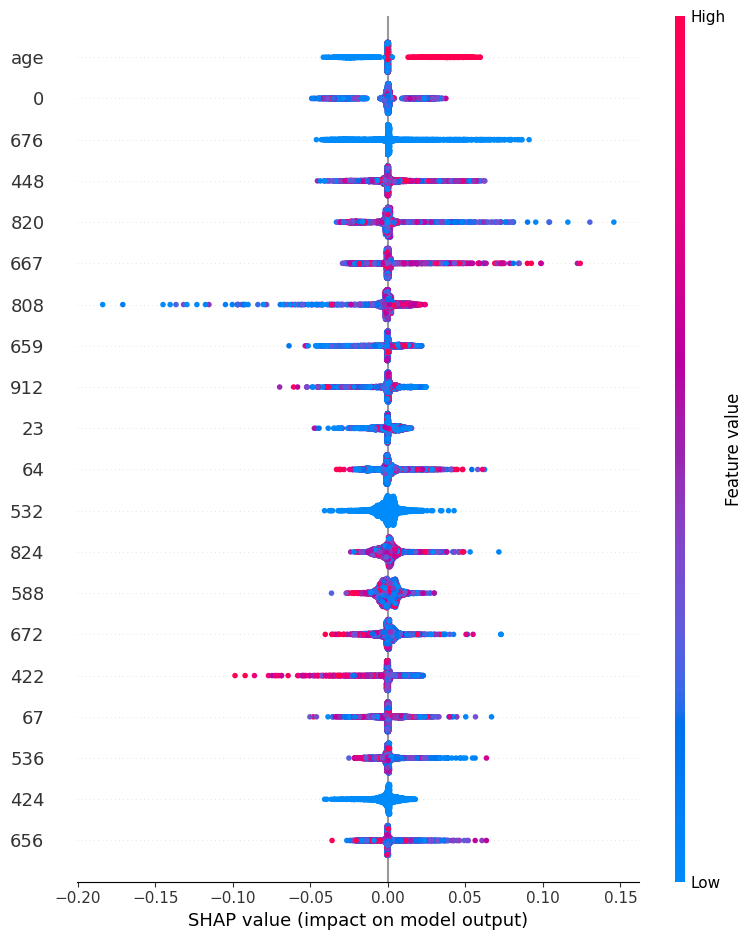

In [52]:
# Stack SHAP values for all diseases
shap_values_combined = shap_values.reshape(-1, shap_values.shape[1])  # Shape: (num_samples*num_outputs, num_features)
test_samples_combined = np.repeat(test_samples_np, len(diseases), axis=0)

# Create a combined feature names list
feat_names_extended = feat_names

# Plot the beeswarm plot
shap.summary_plot(
    shap_values_combined,
    test_samples_combined,
    feature_names=feat_names_extended
)
